In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sy
import random
from scipy.special import sph_harm 
from scipy.special import legendre
from scipy import integrate
from scipy.integrate import dblquad
from scipy.integrate import quad
from datetime import datetime
from matplotlib import cm
%run -i def_func.ipynb
%run -i func_sph_harm.ipynb

Input Streamfunction:

$$
A = random(-1,1)
$$

$$
E(n)=\frac{n}{1.5}exp(-\frac{n}{1.5})
$$

$$
\eta(n)=2\nu n^2(n+1)^2E(n) = 2\nu n^2(n+1)^2\frac{1}{2}\sum_{\lvert m \rvert=0}^n n(n+1)\lvert \psi_{nm} \rvert^2
$$

$$
\psi_{nm}=A*E(n)
$$

$$
U(\theta, \phi)=-\frac{1}{r} \frac{\partial \psi}{\partial \phi} 
$$

$$
V(\theta, \phi)=\frac{\sin \theta}{r}\frac{\partial \psi}{\partial \theta} 
$$

In [2]:
DT= datetime.now()
N_t = 50
N_p = 100
theta = np.linspace(0, np.pi, N_t) #100pts 
phi = np.linspace(0, 2*np.pi, N_p)  #200pts
t, p = np.meshgrid(theta, phi) #create a matrix with size theta x phi (100x200), 20000 pts

lMax = 32 #lMax is N
omega = 1 #omega is te angular rotation
nu = 0.01  #\nu is kinematic viscosity
dt=0.01 #time step
#T = 2.88/dt #total time
T = 288
r = 1 #let r=1

A= 0.44629527092273213


/tmp/ipykernel_1785/3494958942.py:17: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(eta_n/(2*nu)))


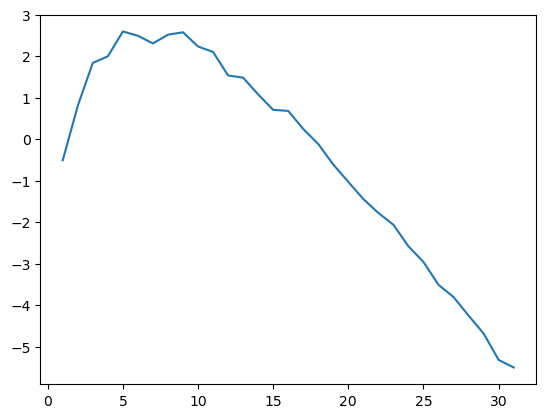

In [3]:
x=[]
y=[]
psi_nm = np.zeros((lMax,lMax))
E = np.zeros(lMax)
eta_n = np.zeros(lMax)
for m in range (lMax): 
    for n in range (m, lMax):
        A = random.uniform(-1,1)
        En = (n/1.5)*np.exp(-n/1.5)
        #En=1
        psi_nm[n,m] = A*En
        E[n] += (1/2)*n*(n+1)*psi_nm[n,m]**2
        eta_n[n] += 2*nu*n**2*(n+1)**2*(1/2)*n*(n+1)*psi_nm[n,m]**2
        x.append(eta_n)
        y.append((2*nu)**(-1)*n)
print('A=',A)        
plt.plot(np.log10(eta_n/(2*nu)))

plt.show()
#print(psi_nm)
#print(eta_n)

(100, 50)


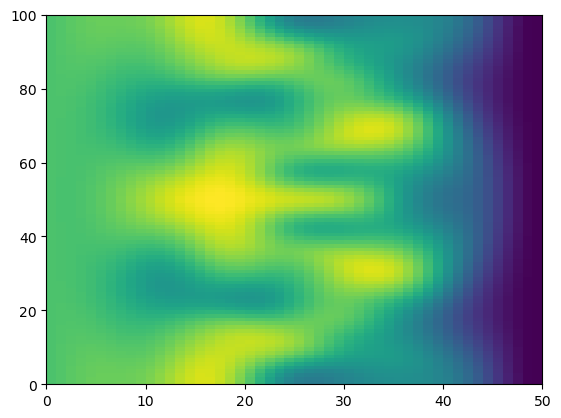

In [4]:
psi_tp = reconstruction(psi_nm, theta, phi, lMax)
print(psi_tp.shape)
plt.pcolormesh(psi_tp.real)

In [5]:
U_tp = -(1/r)*np.gradient(psi_tp, phi, axis=0)
V_tp = (np.sin(t)/r)*np.gradient(psi_tp, theta, axis=1)
u_nm = projection(U_tp, theta, phi, lMax) #project U_tp to u_nm
v_nm = projection(V_tp, theta, phi, lMax)
print(U_tp.shape)

(100, 50)


Analytical expression of different quantities:
$$
\zeta = (\nabla \times \hat{u})_r = \frac{1}{r\sin\theta}(\frac{\partial}{\partial \theta}(u_\phi\sin\theta)-\frac{\partial}{\partial \phi}u_\theta) = \frac{1}{r\sin\theta}(\frac{\partial}{\partial \theta}V-\frac{\partial}{\partial\phi}\frac{U}{\sin\theta})
$$

$$
\zeta_{nm} = (\nabla^2 \psi)_{nm} = -n(n+1)\psi_{nm}
$$

$$
U'(\theta, \phi)=V\zeta+2\Omega V \cos\theta
$$

$$
V'(\theta, \phi)=-U\zeta-2\Omega U \sin \theta
$$

$$
\nabla^2P=-\frac{\partial U'}{\partial \cos\theta}+\frac{1}{\sin^2\theta}\frac{\partial V'}{\partial \phi} = \frac{1}{\sin\theta}\frac{\partial U'}{\partial \theta}+\frac{1}{\sin^2\theta}\frac{\partial V'}{\partial \phi}
$$

$$
p_{nm}=\frac{-1}{n(n+1)}(\nabla^2P)_{nm}
$$

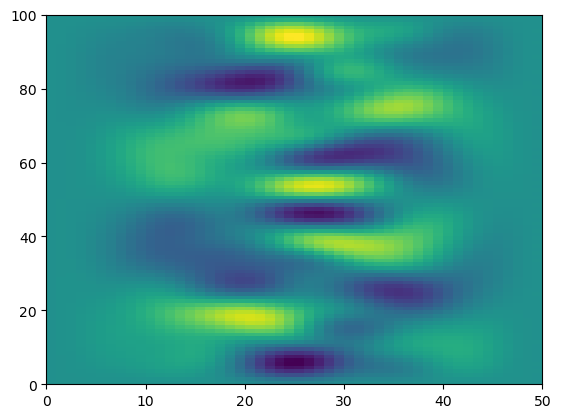

In [6]:
plt.pcolormesh(U_tp.real)
plt.show()

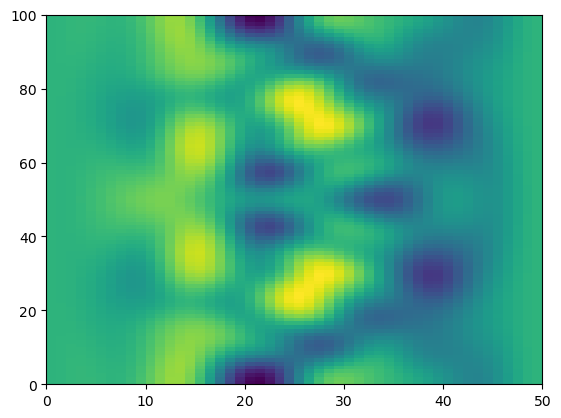

In [7]:
plt.pcolormesh(V_tp.real)
plt.show()

In [8]:
dvdt = np.gradient(V_tp, theta, axis=1)
usin = fsin(U_tp, theta, phi, lMax)
dusindp = np.gradient(usin, phi, axis=0)
zeta_tp = (1/r)*fsin(dvdt-dusindp, theta, phi, lMax)
zeta_nm = projection(zeta_tp, theta, phi, lMax)

In [9]:
U1_tp = V_tp*zeta_tp+2*omega*np.cos(t)*V_tp #U'(theta, phi)
V1_tp = -1*U_tp*zeta_tp-2*omega*np.cos(t)*U_tp #V'(theta, phi)
u1_nm = projection(U1_tp, theta, phi, lMax) #u'_nm
v1_nm = projection(V1_tp, theta, phi, lMax) #v'_nm

In [10]:
du1dt = np.gradient(U1_tp, theta, axis=1)
divP1 = fsin(du1dt, theta, phi, lMax)
dv1dp = np.gradient(V1_tp, phi, axis=0)
sin1 = fsin(dv1dp, theta, phi, lMax)
divP2 = fsin(sin1, theta, phi, lMax)
divP = divP1 + divP2 #\nabla^1 P
divP_nm = projection(divP, theta, phi, lMax) #\nabla^2 P_nm
p_nm = pressure(U_tp, V_tp, zeta_tp, omega, theta, phi, lMax)
P = reconstruction(p_nm, theta, phi, lMax)

In [11]:
print(np.max(u_nm))
print(np.max(v_nm))
print(np.max(u1_nm))
print(np.max(v1_nm))
print(np.max(p_nm))

(3.524741262750375e-16+0.00047918194597639365j)
(0.3554318509788816+0j)
(0.41049893592023184+0j)
(1.1039346520247406e-15-0.0009506375480580875j)
(0.1248360379317028-4.427158870982476e-16j)


Analytical expression for u_dt and v_dt:
$$
\begin{equation}
    \begin{aligned}
        \frac{u^{t+\Delta t}_{nm}-u^{t}_{nm}}{\Delta t} = & u'_{nm}+(n+2)(n+m+1)(2n+3)^{-1}p_{n+1,m} \\
        & +(n-m)(1-n)(2n-1)^{-1}p_{n-1,m}-\nu n(n+1)u^t_{nm}
    \end{aligned}
\end{equation}
$$


$$
\begin{equation}
    v^{t+\Delta t}_{nm} = \frac{1}{im} [B_{np}(n-1)u^{t+\Delta t}_{n-1,m} + B_{nm}(n+1)u^{t+\Delta t}_{n+1,m}]
\end{equation}
$$

with 

$$
B_{np}(n)=-n(n-m+1)(2n+1)^{-1}
$$
and 
$$
B_{nm}(n)=(n+1)(n+m)(2n+1)^{-1}
$$

In [12]:
pre = p_nm
u_t = u_nm #u_t is u_nm^(t)
u_dt = np.zeros((lMax, lMax), dtype=complex) #u_dt is u_nm^(t+dt)
v_dt = np.zeros((lMax, lMax), dtype=complex) #v_dt is v_nm^(t+dt)
u1 = u1_nm
ind_t_a = np.arange(0, T) #np.arange(0, T)
DT0 = datetime.now()
for ind_tn in ind_t_a: 
    DT1 = datetime.now()
    tn = ind_tn*dt
    for m in range (0, lMax):
        for n in range (m, lMax):
            if n == lMax-1: #lMax = N, at the boundray b/c of the rang()
                u_dt[n,m] = u_t[n,m]+dt*(u1[n,m]+(n-m)*(1-n)*((2*n-1)**(-1))*pre[n-1,m]-nu*n*(n+1)*u_t[n,m])
            elif n == 0:                
                u_dt[n,m] = u_t[n,m]+dt*(u1[n,m]+(n+2)*(n+m+1)*(2*n+3)**(-1)*pre[n+1,m]-nu*n*(n+1)*u_t[n,m])
            else: 
                u_dt[n,m] = u_t[n,m]+dt*(u1[n,m]+(n+2)*(n+m+1)*((2*n+3)**(-1))*pre[n+1,m]+(n-m)*(1-n)*((2*n-1)**(-1))*pre[n-1,m]-nu*n*(n+1)*u_t[n,m])
    u_t = u_dt #u_dt is the new u_nm
    #plt.pcolormesh(np.real(u_t), shading='auto')
    DT2 = datetime.now()
    for m in range(1, lMax): #calculation for v_nm^(t+dt)
        for n in range(m, lMax):
            if n == 0: 
                v_dt[n,m] = (m*1j)**(-1)*B_nm(n+1,m)*u_t[n+1,m]
            elif n == lMax-1: #lMax = N, at the boundray
                v_dt[n,m] = (m*1j)**(-1)*B_np(n-1,m)*u_t[n-1,m]
            elif n == lMax-2: #lMax = N-1
                v_dt[lMax-2, m] = -1j*B_np(lMax-3,m)*(m**(-1))*u_t[lMax-3,m]
            else: 
                v_dt[n,m] = (m*1j)**(-1)*(B_np(n-1,m)*u_t[n-1,m]+B_nm(n+1,m)*u_t[n+1,m])
    v_t = v_dt
    DT3 = datetime.now()
    #plt.pcolormesh(np.real(v_t), shading='auto')
    U = reconstruction(u_t, theta, phi, lMax) #new U_tp using the new u_nm will be used for the new zeta_tp
    V = reconstruction(v_dt, theta, phi, lMax) #new V_tp using the new v_nm for the new U'_tp, hence the new u'_nm
    z_tp = zeta(U, V, theta, phi, lMax) #new zeta_tp for the new zeta_nm
    
    #print(z_tp.shape)
    pre = pressure(U, V, z_tp, omega, theta, phi, lMax) #p_nm
    U1 = V*z_tp+2*omega*np.cos(t)*V #the new U'_tp
    u1 = projection(U1, theta, phi, lMax) #the new u'_nm
    if ind_tn%40 == 0:
        #np.save(str(ind_tn).zfill(1), (U,V))
        np.save('UV%s.npy' % ind_tn, (U, V))
        z_nm = projection(z_tp, theta, phi, lMax)
        En = np.sum(np.abs(z_nm)**2,axis=1)/2.#/(np.arange(1, lMax)*(np.arange(1, lMax)+1))
        np.save('E%s.npy' % ind_tn, En)
        np.save('zeta%s.npy' %ind_tn, z_tp)
        np.save('pressure%s.npy' %ind_tn, pre)
    #plt.pcolormesh(U.real)    
    DT4 = datetime.now()
DT5 = datetime.now()

In [13]:
print(DT5-DT)

0:19:18.509009


In [14]:
#print(np.max(u1))
print(np.max(u_t))
print(np.max(v_t))

(0.12986609502476676-0.09246999232606781j)
(0.14912243719118945+0.03073572704079364j)


In [15]:
u00, v00 = np.load('UV0.npy')
u40, v40 = np.load('UV40.npy')
u80, v80 = np.load('UV80.npy')
u120, v120 = np.load('UV120.npy')
u160, v160 = np.load('UV160.npy')
u200, v200 = np.load('UV200.npy')
u240, v240 = np.load('UV240.npy')
u280, v280 = np.load('UV280.npy')

En00 = np.load('E0.npy')
En40 = np.load('E40.npy')
En80 = np.load('E80.npy')
En120 = np.load('E120.npy')
En160 = np.load('E160.npy')
En200 = np.load('E200.npy')
En240 = np.load('E240.npy')
En280 = np.load('E280.npy')

zeta00 = np.load('zeta0.npy')
zeta40 = np.load('zeta40.npy')
zeta80 = np.load('zeta80.npy')
zeta120 = np.load('zeta120.npy')
zeta160 = np.load('zeta160.npy')
zeta200 = np.load('zeta200.npy')
zeta240 = np.load('zeta240.npy')
zeta280 = np.load('zeta280.npy')

pre00 = np.load('pressure0.npy')
pre40 = np.load('pressure40.npy')
pre80 = np.load('pressure80.npy')
pre120 = np.load('pressure120.npy')
pre160 = np.load('pressure160.npy')
pre200 = np.load('pressure200.npy')
pre240 = np.load('pressure240.npy')
pre280 = np.load('pressure280.npy')

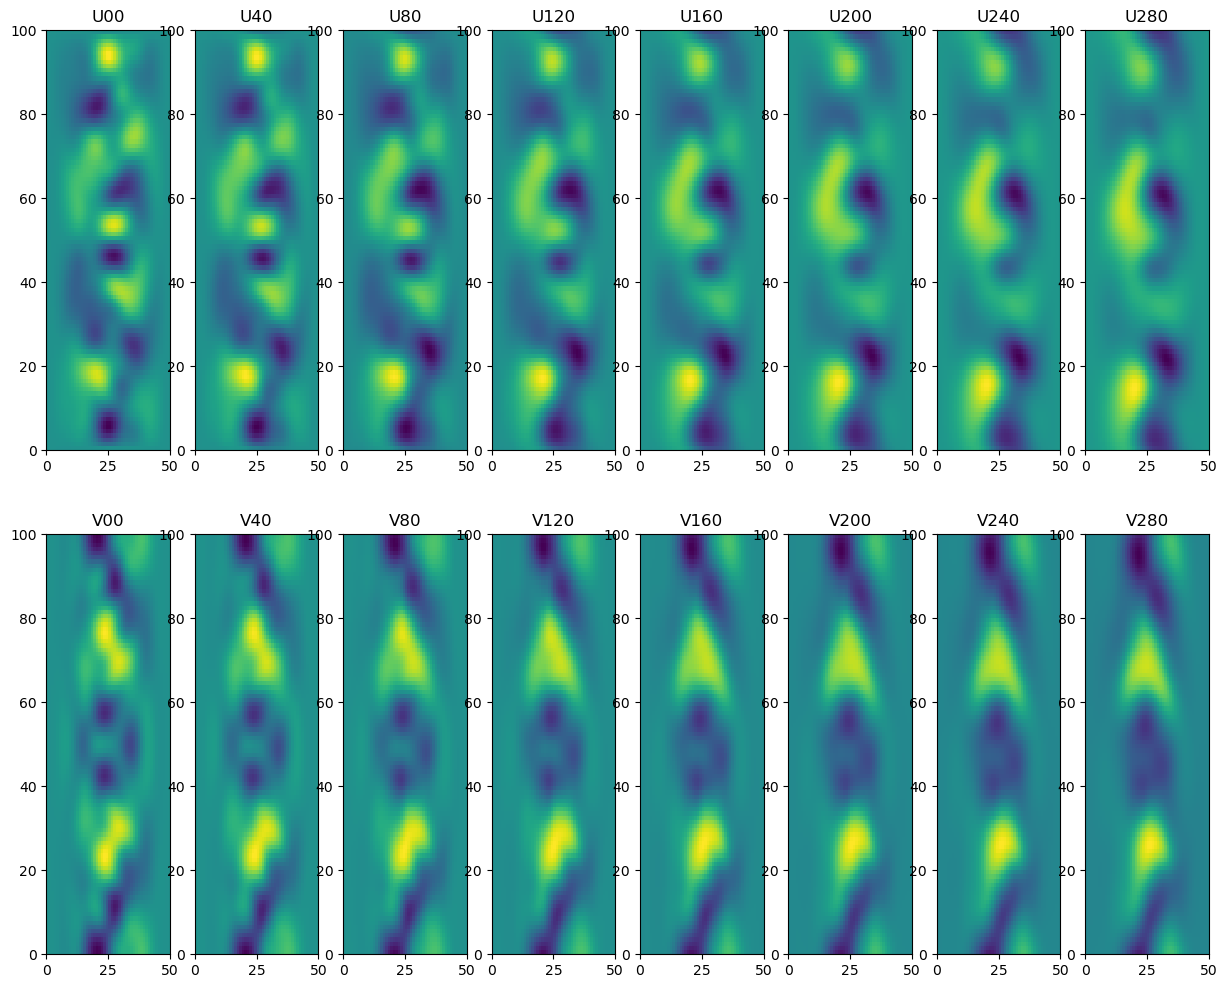

In [33]:
fig, ax = plt.subplots(2,8, figsize=(15, 12))

ax[0, 0].pcolormesh(u00.real)
ax[0, 0].title.set_text('U00')
ax[0, 1].pcolormesh(u40.real)
ax[0, 1].title.set_text('U40')
ax[0, 2].pcolormesh(u80.real)
ax[0, 2].title.set_text('U80')
ax[0, 3].pcolormesh(u120.real)
ax[0, 3].title.set_text('U120')
ax[0, 4].pcolormesh(u160.real)
ax[0, 4].title.set_text('U160')
ax[0, 5].pcolormesh(u200.real)
ax[0, 5].title.set_text('U200')
ax[0, 6].pcolormesh(u240.real)
ax[0, 6].title.set_text('U240')
ax[0, 7].pcolormesh(u280.real)
ax[0, 7].title.set_text('U280')

ax[1, 0].pcolormesh(v00.real)
ax[1, 0].title.set_text('V00')
ax[1, 1].pcolormesh(v40.real)
ax[1, 1].title.set_text('V40')
ax[1, 2].pcolormesh(v80.real)
ax[1, 2].title.set_text('V80')
ax[1, 3].pcolormesh(v120.real)
ax[1, 3].title.set_text('V120')
ax[1, 4].pcolormesh(v160.real)
ax[1, 4].title.set_text('V160')
ax[1, 5].pcolormesh(v200.real)
ax[1, 5].title.set_text('V200')
ax[1, 6].pcolormesh(v240.real)
ax[1, 6].title.set_text('V240')
ax[1, 7].pcolormesh(v280.real)
ax[1, 7].title.set_text('V280')

plt.savefig('U_V.pdf')
fig.show()

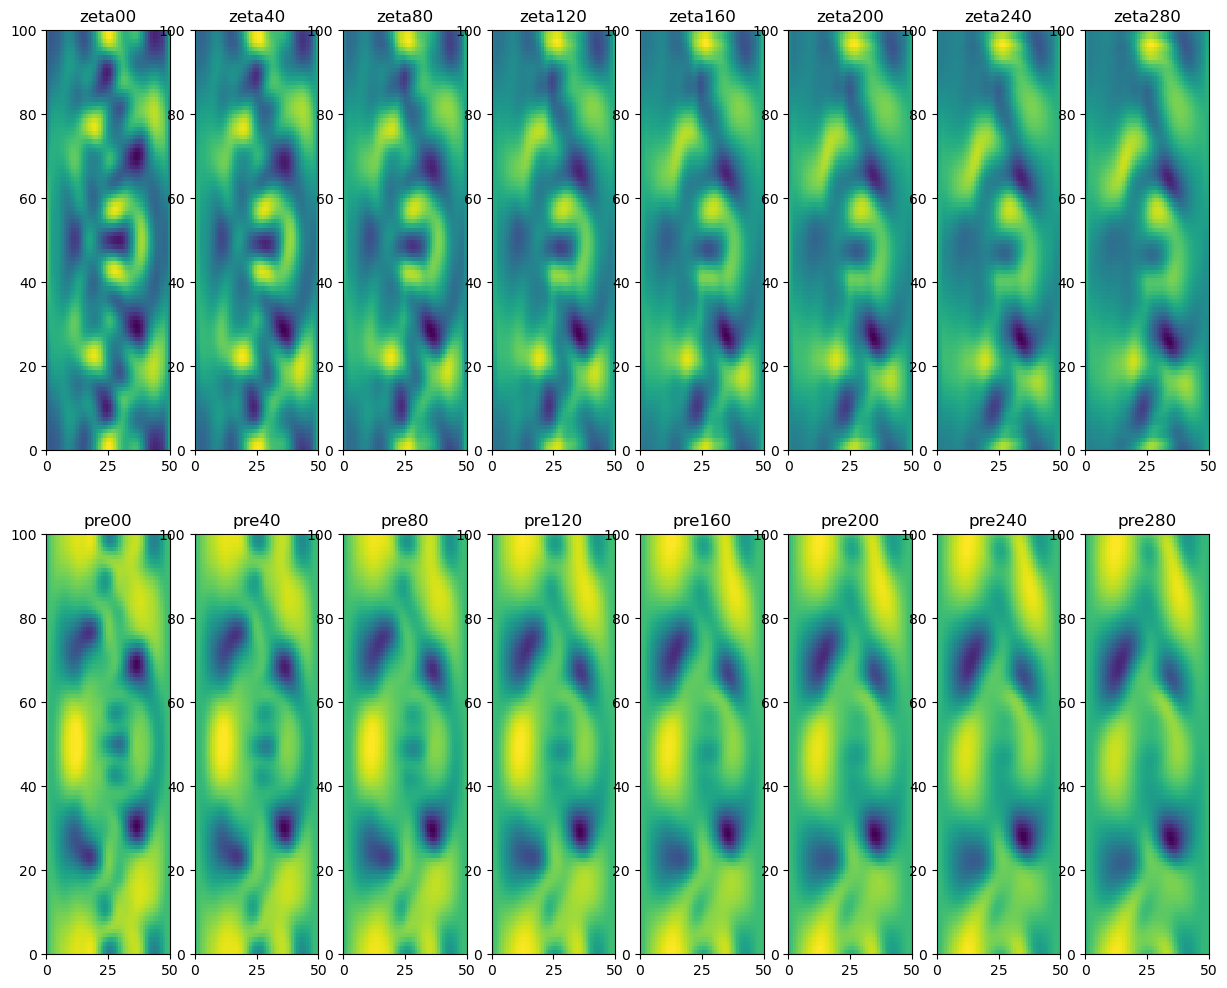

In [34]:
fig, ax = plt.subplots(2,8, figsize=(15,12))
ax[0, 0].pcolormesh(zeta00.real)
ax[0, 0].title.set_text('zeta00')
ax[0, 1].pcolormesh(zeta40.real)
ax[0, 1].title.set_text('zeta40')
ax[0, 2].pcolormesh(zeta80.real)
ax[0, 2].title.set_text('zeta80')
ax[0, 3].pcolormesh(zeta120.real)
ax[0, 3].title.set_text('zeta120')
ax[0, 4].pcolormesh(zeta160.real)
ax[0, 4].title.set_text('zeta160')
ax[0, 5].pcolormesh(zeta200.real)
ax[0, 5].title.set_text('zeta200')
ax[0, 6].pcolormesh(zeta240.real)
ax[0, 6].title.set_text('zeta240')
ax[0, 7].pcolormesh(zeta280.real)
ax[0, 7].title.set_text('zeta280')

ax[1, 0].pcolormesh(reconstruction(pre00, theta, phi, lMax).real)
ax[1, 0].title.set_text('pre00')
ax[1, 1].pcolormesh(reconstruction(pre40, theta, phi, lMax).real)
ax[1, 1].title.set_text('pre40')
ax[1, 2].pcolormesh(reconstruction(pre80, theta, phi, lMax).real)
ax[1, 2].title.set_text('pre80')
ax[1, 3].pcolormesh(reconstruction(pre120, theta, phi, lMax).real)
ax[1, 3].title.set_text('pre120')
ax[1, 4].pcolormesh(reconstruction(pre160, theta, phi, lMax).real)
ax[1, 4].title.set_text('pre160')
ax[1, 5].pcolormesh(reconstruction(pre200, theta, phi, lMax).real)
ax[1, 5].title.set_text('pre200')
ax[1, 6].pcolormesh(reconstruction(pre240, theta, phi, lMax).real)
ax[1, 6].title.set_text('pre240')
ax[1, 7].pcolormesh(reconstruction(pre280, theta, phi, lMax).real)
ax[1, 7].title.set_text('pre280')


fig.show()
plt.savefig('zeta_pressure.pdf')

/tmp/ipykernel_1785/3063032856.py:1: RuntimeWarning: invalid value encountered in divide
  e_n = 2*nu*np.arange(lMax)**2*(np.arange(lMax)+1)**2*En00.real/(np.arange(lMax)*(np.arange(lMax)+1))
/tmp/ipykernel_1785/3063032856.py:2: RuntimeWarning: invalid value encountered in divide
  e_n1 = 2*nu*np.arange(lMax)**2*(np.arange(lMax)+1)**2*En280.real/(np.arange(lMax)*(np.arange(lMax)+1))


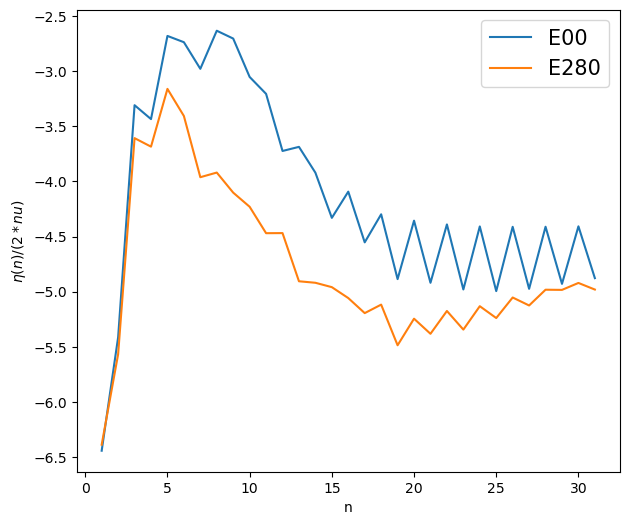

In [25]:
e_n = 2*nu*np.arange(lMax)**2*(np.arange(lMax)+1)**2*En00.real/(np.arange(lMax)*(np.arange(lMax)+1))
e_n1 = 2*nu*np.arange(lMax)**2*(np.arange(lMax)+1)**2*En280.real/(np.arange(lMax)*(np.arange(lMax)+1))
plt.plot(np.log10(e_n/2*nu), label='E00')
plt.plot(np.log10(e_n1/2*nu), label='E280')
plt.xlabel('n')
plt.ylabel('$\eta(n)/(2*nu)$')
plt.rcParams["figure.figsize"] = (7, 6)
plt.legend(loc=1, fontsize=15)
plt.savefig('eta.pdf')
plt.show()